# Rotation Thrust Analysis

Analysis leading up to the rotation thrust experimental days. Goals include

1. Determine feasability of localized NTV within DIII-D given the current coils.
2. Determine sensitivity to omega_E zero crossing.

## Notebook Settings

Populating the interactive namespace from numpy and matplotlib


/usr/pppl/Anaconda/2.3.0/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


<IPython.core.display.Javascript object>


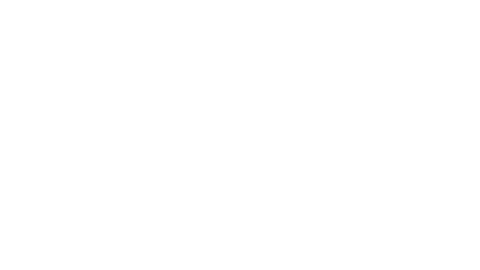

Failed to import gui - must have enthought.traits


In [1]:
%pylab notebook

import sys
if '/p/gpec/users/nlogan/gpec' not in sys.path:
    sys.path.append('/p/gpec/users/nlogan/gpec')
from pypec import data,gpec,post

import seaborn
seaborn.set_palette('colorblind')

## Shot 163113

The kinetic EFIT gfile for this shot was supplied by Colin Chrystal. He and Brian like this shot because they get accurate transport modeling with TGLF.

There was some discussion as to wether or not we should include the fast ions in the ion density profile. I believe I opted for the profile without, although Colin supplied both.

There were some unit conversions required between Colin's profile table and the correct PENT inputs. See below.


### Prep

In [7]:
def kinetic_file_formatter(pfile='g163113.03600_profiles.txt', kdir='/p/gpec/users/nlogan/data/d3d/kinetics'):
    """
    Convert Colin ascii tables to pent files format.

    :param gfile:
    :param kdir:
    :return:

    """
    # variables
    kdir = kdir.rstrip('/') + '/'

    # name and unit conversions
    ynames = ['ni(m^-3)', 'ne(m^-3)', 'ti(eV)', 'te(eV)', 'omega_E(rad/s)']
    onames = ['ni_thcm^3', 'necm^3', "TikeV", "TekeV", "w_EXBkHz"]
    convrt = [1e6, 1e6, 1e3, 1e3, 2*np.pi*1e3]

    okin = data.read(kdir + pfile, squeeze=True)
    # convert to pent units
    for y, o, c in zip(ynames, onames, convrt):
        okin.y[y] = okin.y[o] * c
    data.write(okin, fname=kdir + pfile.replace('.txt', '_PENTformat.txt'), ynames=ynames)
    okin.plot1d(ynames)
    okin.plot1d(onames)

    return True

Casting table 1 into Data object.


<IPython.core.display.Javascript object>


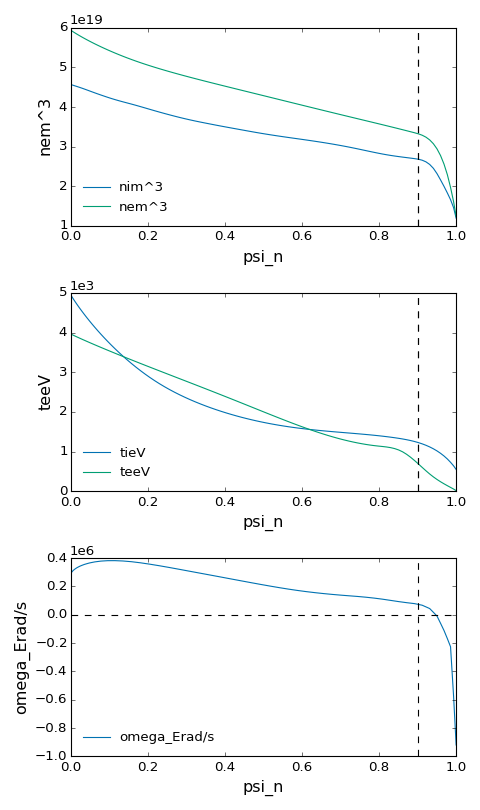

In [8]:
kin163113 = data.open_dataset('/p/gpec/users/nlogan/data/d3d/kinetics/g163113.03600_profiles_PENTformat.txt')
f,ax = data.plt.subplots(3)
for k in kin163113.data_vars.keys():
    if k.startswith('n'):
        a = ax[0]
    elif k.lower().startswith('t'):
        a = ax[1]
    else:
        a = ax[2]
    kin163113[k].plot(ax=a,label=k)
    a.axvline(x=0.9,linestyle='--',color='k')
    a.legend()
ax[-1].axhline(0,ls='--',color='k')

### Analysis

First, we read the netcdf gpec results

In [33]:
root = '/p/gpec/users/nlogan/data/d3d/2016_rotationthrust/g163113.03600/n2/kinetic/full_ie/'
con = data.open_dataset(root+'gpec_control_output_n2.nc')
prof = data.open_dataset(root+'gpec_profile_output_n2.nc')
cyl = data.open_dataset(root+'gpec_cylindrical_output_n2.nc')

The first thing we will look at is the self-consistent torque matrices, which relate the spectrum on the plasma control surface to the integral torque inside a given flux surface. 

The matrices show the torque is primarily from mid-m near m >~ q_lim = 6.6. Note this is not the pitch resonance m = nq_lim ~ 13.

<IPython.core.display.Javascript object>


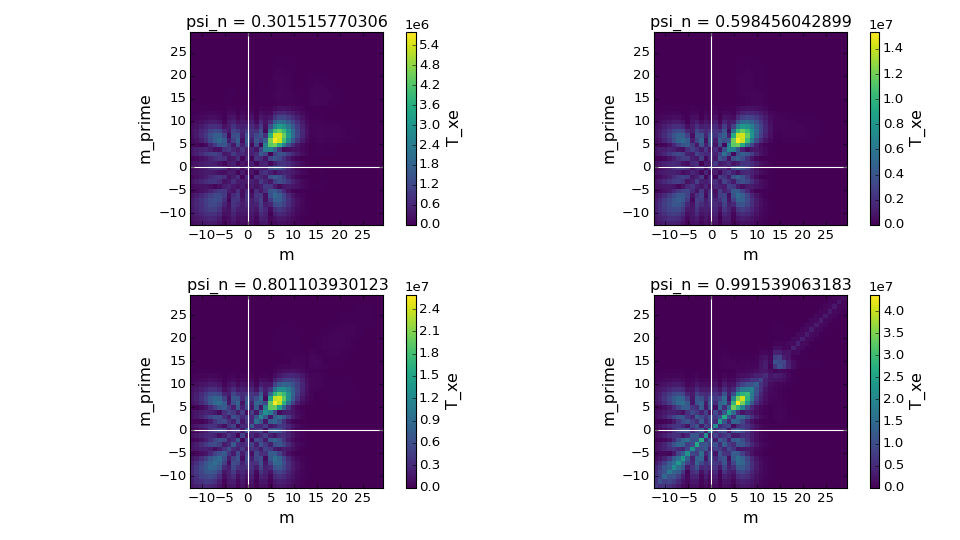

In [34]:
f,ax = data.plt.subplots(2,2,subplot_kw={'aspect':'equal'})
for i,psi in enumerate([0.3,0.6,0.8,1.0]):
    np.abs(prof['T_xe'].sel(psi_n=psi,method='nearest')).plot(ax=ax.flat[i])
    ax.flat[i].axvline(0,color='w')
    ax.flat[i].axhline(0,color='w')

Check that these are hermitian.

<IPython.core.display.Javascript object>


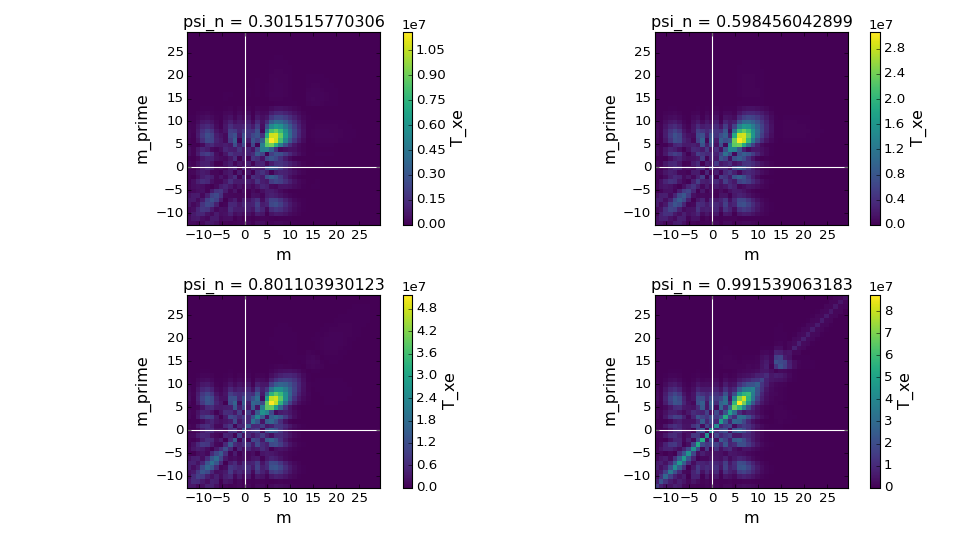

<IPython.core.display.Javascript object>


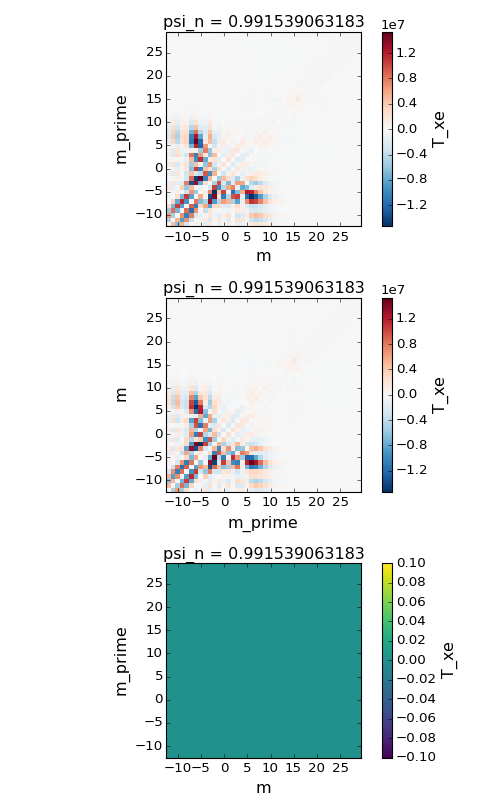

In [44]:
def hermitian(mat):
    return mat#(mat + mat.conj().T) / 2.0
def antihermitian(mat):
    return mat - mat.conj().T

f,ax = data.plt.subplots(2, 2, subplot_kw={'aspect':'equal'})
for i,psi in enumerate([0.3,0.6,0.8,1.0]):
    np.abs(antihermitian(prof['T_xe'].sel(psi_n=psi,method='nearest'))).plot(ax=ax.flat[i])
    ax.flat[i].axvline(0,color='w')
    ax.flat[i].axhline(0,color='w')

f,ax = data.plt.subplots(3, 1, subplot_kw={'aspect':'equal'})
prof['T_xe'].sel(psi_n=1.,method='nearest').real.plot(ax=ax.flat[0])
prof['T_xe'].sel(psi_n=1.,method='nearest').T.real.plot(ax=ax.flat[1])
(prof['T_xe'].sel(psi_n=1.,method='nearest').real - prof['T_xe'].sel(psi_n=1.,method='nearest').T.real).plot(ax=ax.flat[2])




Notice that all the matrices look qualitatively similar to the eye. In order to optimize localized torque, we must utilize the subtle differences between the matrices at differing radii. Luckily, there are additional differences in the complex phase of the matrix components.

<IPython.core.display.Javascript object>


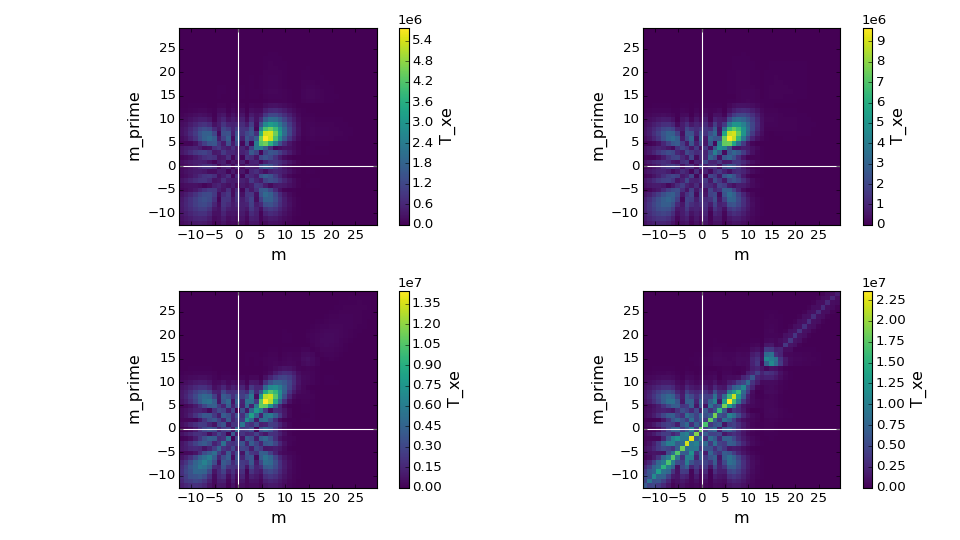

In [11]:
f,ax = data.plt.subplots(2,2,subplot_kw={'aspect':'equal'})
for i,psi in enumerate([0.3,0.6,0.8,1.0]):
    Delta = prof['T_xe'].sel(psi_n=psi,method='nearest') - prof['T_xe'].sel(psi_n=psi-0.3,method='nearest')
    np.abs(Delta).plot(ax=ax.flat[i])
    ax.flat[i].axvline(0,color='w')
    ax.flat[i].axhline(0,color='w')

These differences can create the following torque profiles. Note the profiles are normalized to the input external-flux energy.

<IPython.core.display.Javascript object>


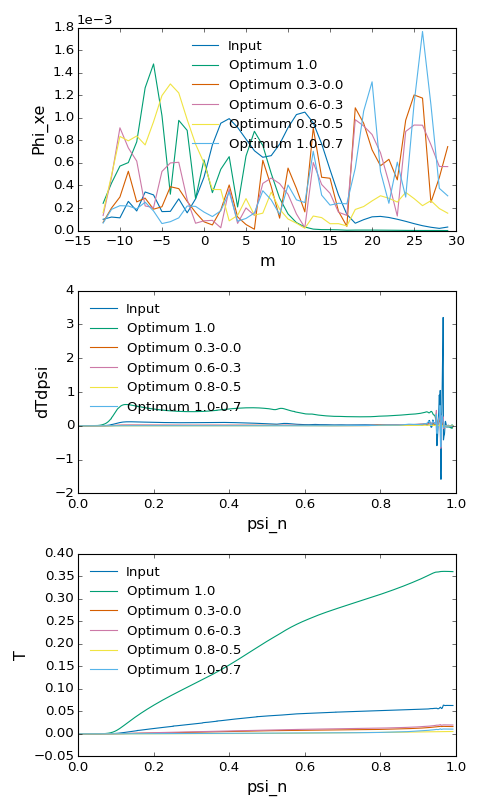

In [12]:
f,ax = data.plt.subplots(3)

input_power = np.dot(con['Phi_xe'].conj(), con['Phi_xe']).real 
T_mat = prof['T_xe'].transpose('psi_n', 'm_prime', 'm') # order matters in  dot products
T_mat = (T_mat + T_mat.T.conj())/2. # Hermitian cleanup
T_mat /= sqrt(con.attrs['area']) # area norm is bug in 1.0.1

# coil input result
l = np.abs(con['Phi_xe']).plot(ax=ax[0], label='Input')
prof['dTdpsi_n'] = prof['dTdpsi']*0 + np.gradient(prof['T'])
l = prof['dTdpsi'].real.plot(ax=ax[1], label='Input')
l = prof['T'].real.plot(ax=ax[2], label='Input')

# total torque optimum 
w,v = post.optimize_torque(prof['T_xe'],psihigh=1.0)
T_opt = np.real(np.dot(np.dot(v.T.conj(), T_mat), v))/2
l, = ax[0].plot(con['m'], np.abs(v) * np.sqrt(input_power), label='Optimum 1.0')
l, = ax[1].plot(prof['psi_n'], np.gradient(T_opt*input_power)/np.gradient(prof['psi_n']), label='Optimum 1.0')
l, = ax[2].plot(prof['psi_n'], T_opt*input_power, label='Optimum 1.0')

# localized torque optima
for i,psi in enumerate([0.3,0.6,0.8,1.0]):
    w,v = post.optimize_torque(prof['T_xe'],psilow=psi-0.3,psihigh=psi, normalize=True)
    T_opt = np.real(np.dot(np.dot(v.T.conj(), T_mat), v))/2
    l, = ax[0].plot(con['m'], np.abs(v) * np.sqrt(input_power), label='Optimum {:}-{:}'.format(psi,psi-0.3))
    l, = ax[1].plot(prof['psi_n'], np.gradient(T_opt*input_power)/np.gradient(prof['psi_n']), label='Optimum {:}-{:}'.format(psi,psi-0.3))
    l, = ax[2].plot(prof['psi_n'], T_opt*input_power, label='Optimum {:}-{:}'.format(psi,psi-0.3))

for a in ax:
    a.legend()

So this actually doesn't look very promissing. We see the "localized" torque densities are not very peaked, and that their total torques are an order of magnitude below the simple aligned coils or 2 orders of magnitude below the global maximum.

---

> NOTE: The local optima *without* normalization give larger torques than the total optimum. **This indicates a bug!!**

---

Even if the optima where good profiles, the spectra required to make them are clearly prohibitively complex. They involve large amounts of the short wavelength, high-|m| modes. The effects of these modes are probably not numerically well constrained by the DCON eigenfunctions (the idea being that they shouldn't be large in a reasonable physical system). Note that many of the optimized profiles require large amounts of anti-helicity applied flux. There doesn't seem to be a clear trend in the preference of anti/plasma helicity from core to edge. The global optimum has a lot of anti-helicity, which seems suprising as I would expect it to take maximum advantage of plasma amplification at +helicities.


With the full spectral control not providing cleanly localized torques, I do not expect the coils have much wiggle room at all. Lets se what they can do,

<IPython.core.display.Javascript object>


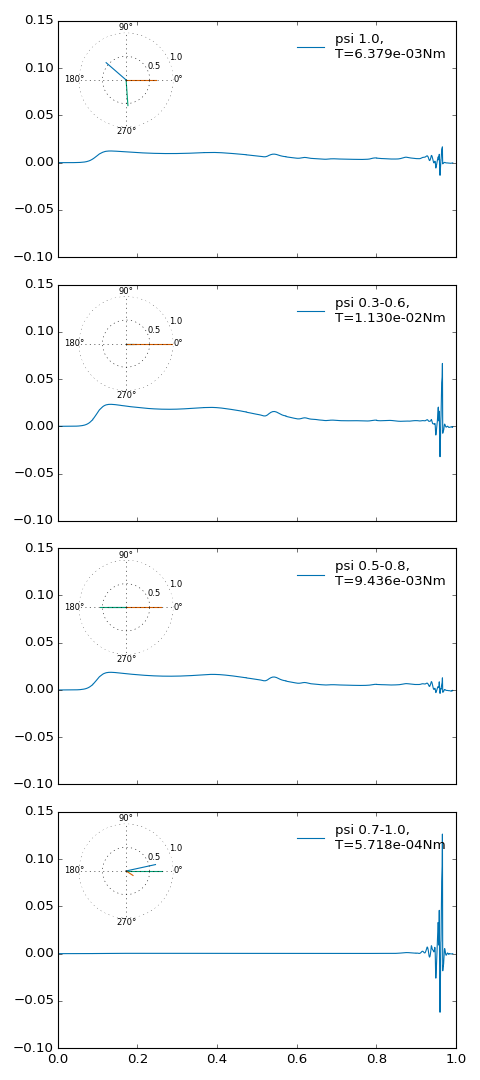


psi 0.3-0.6, T=1.130e-02Nm
coil     amp      ang     
0        0.21     -1.197e-13
1        0.15     -9.263e-14
2        0.97     +0.00000

psi 0.5-0.8, T=9.436e-03Nm
coil     amp      ang     
0        0.38     -180.000
1        0.56     +180.000
2        0.74     +0.00000

psi 0.7-1.0, T=5.718e-04Nm
coil     amp      ang     
0        0.64     +12.2600
1        0.75     +0.00000
2        0.17     -32.9800


In [13]:
f,ax = data.plt.subplots(4, sharex=True, sharey=True)
plt.draw() # drawing updates that axes positions with autolayout

def insert_polar(ax,rect):
    """Inset a polar axis in the parent axes"""
    ina = data.plt.add_inset_axes(ax,rect,polar=True)
    ina.set_xticks([0,pi/2,pi,3*pi/2]) #([0,90,180,270])
    ina.set_yticks([0.5,1,1.5,2])
    ina.set_ylim(0,1)
    ina.spines['polar'].set_visible(False)
    return ina

T_coil = prof['T_coil'].transpose('psi_n', 'coil_index_prime', 'coil_index') # order matters in  dot products
T_coil = (T_coil + T_coil.T.conj())/2. # Hermitian cleanup
T_coil /= sqrt(con.attrs['area']) # area norm is bug in 1.0.1

# total torque optimum 
w,v = post.optimize_torque(prof['T_coil'],psihigh=1.0)
T_opt = np.real(np.dot(np.dot(v.T.conj(), T_coil), v))/2
l, = ax[0].plot(prof['psi_n'], np.gradient(T_opt)/np.gradient(prof['psi_n']), label='psi 1.0, \nT={:.3e}Nm'.format(T_opt[-1]))
ina = insert_polar(ax[0],[0.01, 0.55, 0.4, 0.4])
for i in range(3):
    l, = ina.plot([np.angle(v[i])]*2,[0,np.abs(v[i])])

# localized torque optima
for ai,psi in enumerate([0.6,0.8,1.0]):
    w,v = post.optimize_torque(prof['T_coil'],psilow=psi-0.3,psihigh=psi, normalize=True)
    T_opt = np.real(np.dot(np.dot(v.T.conj(), T_coil), v))/2
    l, = ax[ai+1].plot(prof['psi_n'], np.gradient(T_opt)/np.gradient(prof['psi_n']), label='psi {:}-{:}, \nT={:.3e}Nm'.format(psi-0.3,psi,T_opt[-1]))
    ina = insert_polar(ax[ai+1],[0.01, 0.55, 0.4, 0.4])
    print('\npsi {:}-{:}, T={:.3e}Nm'.format(psi-0.3,psi,T_opt[-1]))
    print('{:8} {:8} {:8}'.format('coil','amp','ang'))
    for i in range(3):
        l, = ina.plot([np.angle(v[i])]*2,[0,np.abs(v[i])])
        print('{:<8} {:<8.2} {:<+08.4}'.format(i,np.abs(v[i]),np.angle(v[i],deg=True)))
        
for a in ax:
    a.legend(loc=1)

### Functions for plots comparing theoretical and realizable optima


<IPython.core.display.Javascript object>


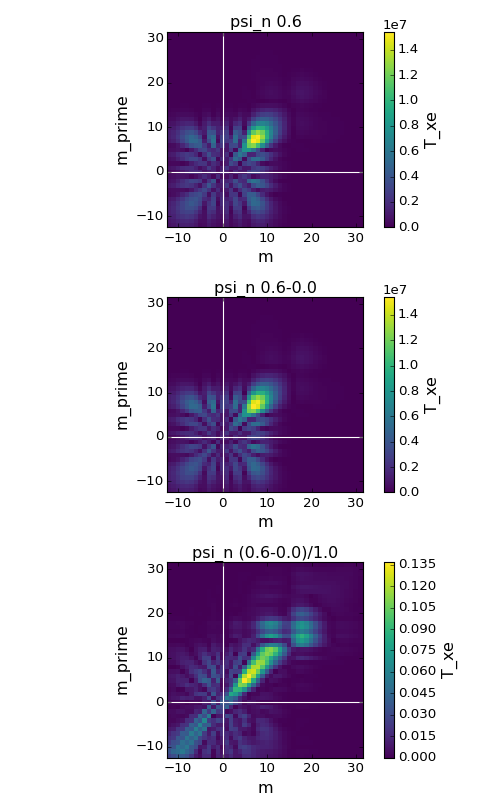

In [27]:
def hermitian(mat):
    return mat#(mat + mat.conj().T) / 2

def white_zeros(ax):
    ax.axvline(0,color='w')
    ax.axhline(0,color='w')

def compare_optima(psilow,psihigh,prof):
    T_xe = hermitian(prof['T_xe']).transpose('psi_n', 'm_prime', 'm')
    w_theory,v_theory = post.optimize_torque(prof['T_xe'],psilow=psilow,psihigh=psihigh, normalize=True)
    T_theory = np.real(np.dot(np.dot(v_theory.T.conj(), T_xe), v_theory))/2
    T_coil = hermitian(prof['T_coil']).transpose('psi_n', 'coil_index_prime', 'coil_index')
    w_attain,v_attain = post.optimize_torque(prof['T_coil'],psilow=psilow,psihigh=psihigh, normalize=True)
    T_attain = np.real(np.dot(np.dot(v_attain.T.conj(), T_coil), v_attain))/2
    
    # plot the theory matrix
    
    Ai = np.linalg.inv(hermitian(prof['T_xe'].sel(psi_n=1, method='nearest'))) + 0*prof['T_xe'].sel(psi_n=1, method='nearest')
    Ah = hermitian(prof['T_xe'].sel(psi_n=psihigh, method='nearest'))
    dA = Ah - hermitian(prof['T_xe'].sel(psi_n=psilow, method='nearest'))
    Ao = np.dot(Ai,dA)  + 0*prof['T_xe'].sel(psi_n=1, method='nearest')
    f,ax = data.plt.subplots(3,1,subplot_kw={'aspect':'equal'})
    abs(Ah).plot(ax=ax[0])
    ax[0].set_title('psi_n {:.2}'.format(psihigh))
    white_zeros(ax[0])
    abs(dA).plot(ax=ax[1])
    ax[1].set_title('psi_n {:.2}-{:.2}'.format(psihigh,psilow))
    white_zeros(ax[1])
    abs(Ao).plot(ax=ax[2])
    ax[2].set_title('psi_n ({h:.2}-{l:.2})/1.0'.format(h=psihigh,l=psilow))
    white_zeros(ax[2])
    
    # plot the spectra
    
    
    #plot the profiles
    
    
    # plot the 3D surfaces and coils (b_n_x and b_n)
    
compare_optima(0.0,0.6,prof)

In [15]:
compare_optima(0.0,0.6,prof)

ValueError: shapes (44,) and (773,3,3) not aligned: 44 (dim 0) != 3 (dim 1)

## Shot 163518

The kinetic efit and profiles for this shot were prepared by Xi Chen using Tom's tools. The shot is under consideration as the target shot for experiments "Extending the operating space to of the low-torque wide-pedestal QH". EHO were observed co-existing with the broadband MHD in some wide-pedestal QH plasmas, and initial analysis shows that EHO can be sustained with edge ExB shear lower than that in standard QH-mode. The new experiments will scan the NBI torque and try to sustain the EHO with NTV.

The two time slices are
- 2350ms, standard high ctr-Ip torque with EHO
- 4300ms, zero-torque with broadband MHD only

### Prep

The kinetic profiles were prepared with the standard p-file formatter.

They show the top of the pedestal moves inward during the zero-torque broad-band (BB) MHD, creating the "wide pedestal QH". The EXB rotation in this BB case oscillates around zero, with a much more shallow and wide "well" at the edge. The original "well" is really a peak in the rotation from an already quite negative core value to very negative around psi 0.95 before it crashes to zero at the boundary.

In [14]:
def pfile_formatter(gfile='g163518.4300', kdir='/p/gpec/users/nlogan/data/d3d/kinetics'):
    """
    Convert p-files to pent files format.
    Note: need to first replace all "256 psinorm" with "<return>psinorm"
    Note: need to remove 3 N Z A of ion species if in file.

    **Arguments:**

    **Key Word Arguments:**

    **Returns:**

    """
    # variables
    pfile = gfile.replace('g', 'p')
    kdir = kdir.rstrip('/') + '/'

    # name and unit conversions
    ynames = ['ni(m^-3)', 'ne(m^-3)', 'ti(eV)', 'te(eV)', 'omega_E(rad/s)']
    #onames = ['ni10^20/m^3', 'ne10^20/m^3', "tiKeV", "teKeV", "omgebkRad/s"]
    onames = ['ni10^20/m^3', 'ne10^20/m^3', "tikev", "tekev", "omgebkrad/s"]
    convrt = [1e20, 1e20, 1e3, 1e3, 1e3]

    okin = data.read(kdir + pfile, squeeze=True)
    # avoid changing capitalization issues:
    for k in okin.y.keys():
        okin.y[k.lower()] = okin.y[k]
    # convert to pent units
    for y, o, c in zip(ynames, onames, convrt):
        okin.y[y] = okin.y[o] * c
    data.write(okin, fname=kdir + pfile + '_PENTformat', ynames=ynames)
    okin.plot1d(ynames)
    okin.plot1d(onames)

    return True

Casting table 1 into Data object.
Casting table 1 into Data object.


<IPython.core.display.Javascript object>


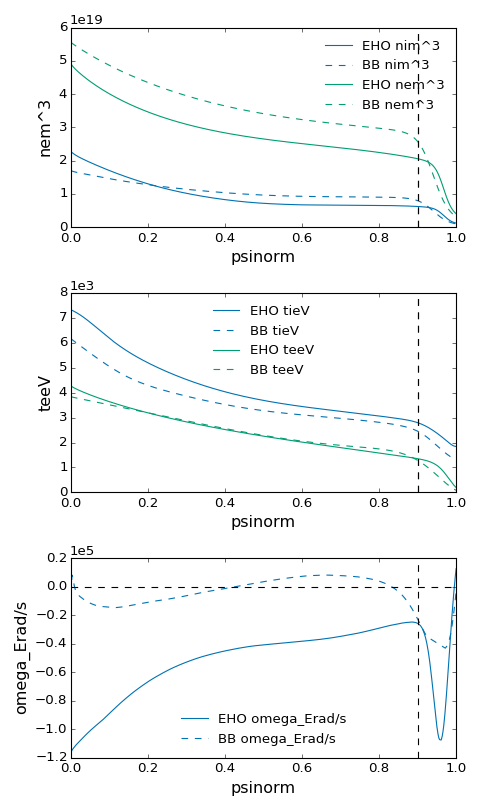

In [15]:
kinh = data.open_dataset('/p/gpec/users/nlogan/data/d3d/kinetics/p163518.02350_PENTformat')
kinl = data.open_dataset('/p/gpec/users/nlogan/data/d3d/kinetics/p163518.04300_PENTformat')
f,ax = data.plt.subplots(3)
for k in kinh.data_vars.keys():
    if k.startswith('n'):
        a = ax[0]
    elif k.lower().startswith('t'):
        a = ax[1]
    else:
        a = ax[2]
    l, = kinh[k].plot(ax=a,label='EHO '+k)
    l, = kinl[k].plot(ax=a,label='BB '+k,ls='--',color=l.get_color())
    a.axvline(x=0.9,linestyle='--',color='k')
    a.legend()
l = ax[-1].axhline(0,linestyle='--',color='k')

## Analysis

First, lets get the data

In [2]:
root_h = '/p/gpec/users/nlogan/data/d3d/2016_qhedge/g163518.02350/'
con_h = data.open_dataset(root_h+'gpec_control_output_n2.nc')
prof_h = data.open_dataset(root_h+'gpec_profile_output_n2.nc')
cyl_h = data.open_dataset(root_h+'gpec_cylindrical_output_n2.nc')
root_l = '/p/gpec/users/nlogan/data/d3d/2016_qhedge/g163518.04300/'
con_l = data.open_dataset(root_l+'gpec_control_output_n2.nc')
prof_l = data.open_dataset(root_l+'gpec_profile_output_n2.nc')
cyl_l = data.open_dataset(root_l+'gpec_cylindrical_output_n2.nc')


Again, we will check the fundemental matrices before getting to the optimizations.

The matrices look very similar to each other. The qlim for the two times are 7.1 (2350ms) and 7.6 (4300ms). The pattern of torque being dominated by m~6-7~qlim clearly persists. I can also see the now familiar broadening of the "cload" around m~m_prime~7 as we move into the core. The edge matrix is more clearly collapsed along the diagonal line m=m_prime.

Interestingly, the edge matrix is the one that shows the largest relative amplitude in the low-m anti-helicity modes. These might penetrate into the core better in vacuum, but the plasma amplification of the plasma helicity higher-m modes more than compensates for this.

<IPython.core.display.Javascript object>


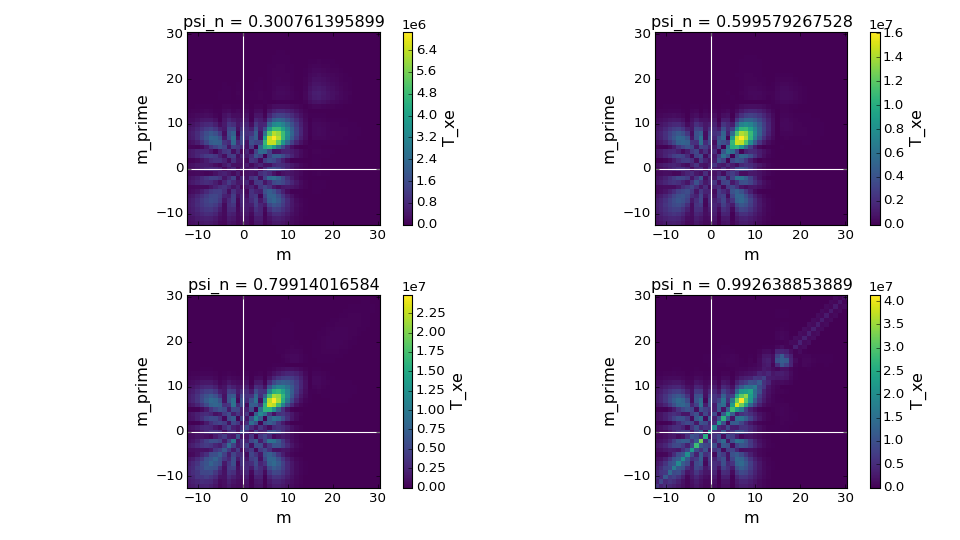

<IPython.core.display.Javascript object>


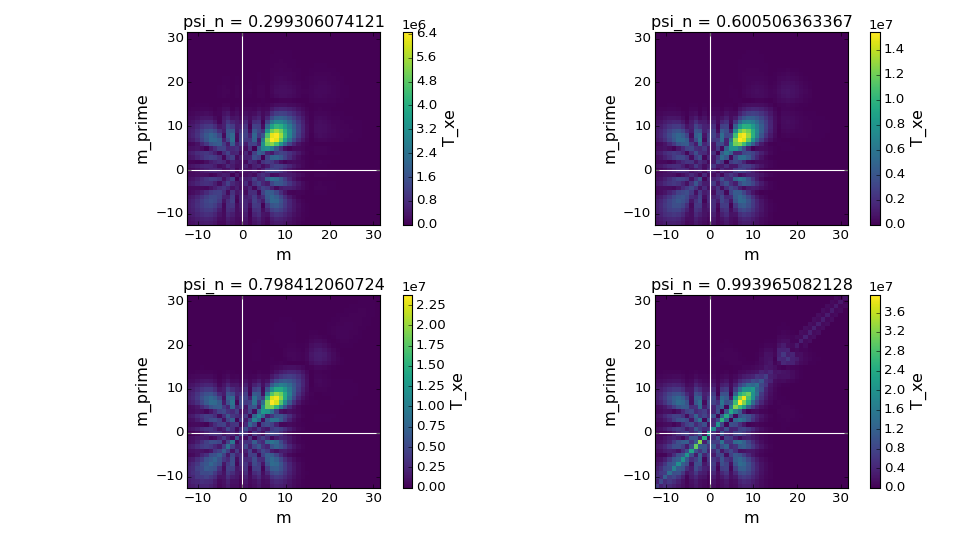

In [26]:
fh,ah = data.plt.subplots(2,2,subplot_kw={'aspect':'equal'})
fl,al = data.plt.subplots(2,2,subplot_kw={'aspect':'equal'})
for i,psi in enumerate([0.3,0.6,0.8,1.0]):
    np.abs(prof_h['T_xe'].sel(psi_n=psi,method='nearest')).plot(ax=ah.flat[i])
    ah.flat[i].axvline(0,color='w')
    ah.flat[i].axhline(0,color='w')
    np.abs(prof_l['T_xe'].sel(psi_n=psi,method='nearest')).plot(ax=al.flat[i])
    al.flat[i].axvline(0,color='w')
    al.flat[i].axhline(0,color='w')

<IPython.core.display.Javascript object>


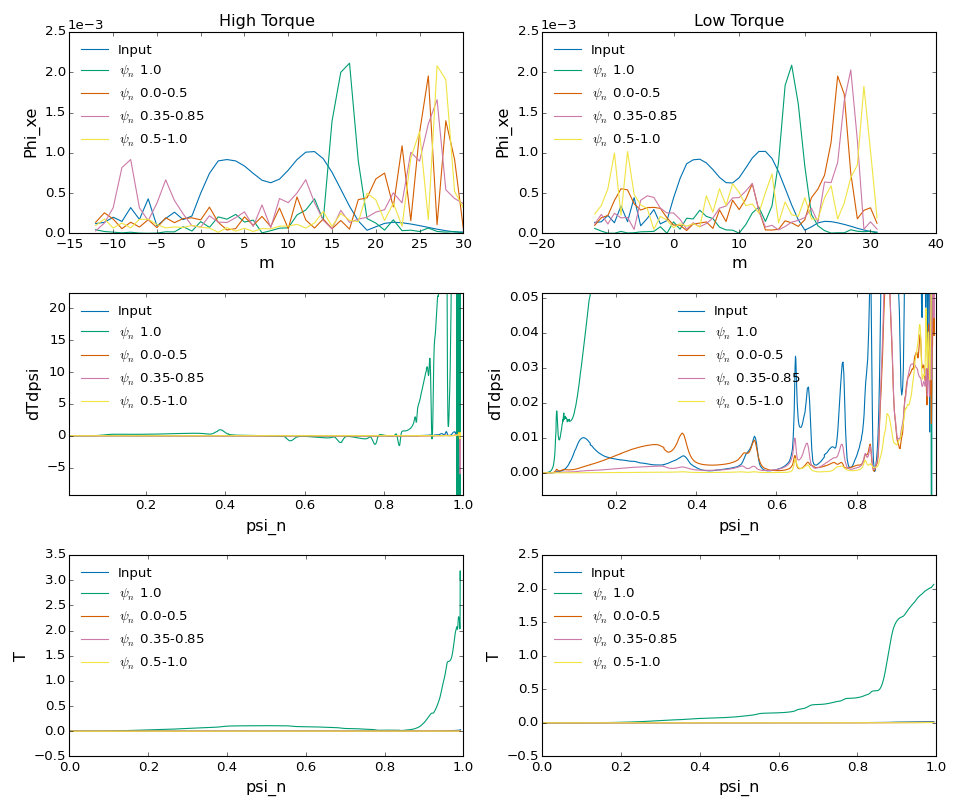

/usr/pppl/Anaconda/2.3.0/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a boolean instead of an integer will result in an error in the future


In [5]:
f,axes = data.plt.subplots(3,2)

for ax,con,prof in [(axes[:,0],con_h,prof_h), (axes[:,1],con_l,prof_l)]:
    input_power = np.dot(con['Phi_xe'].conj(), con['Phi_xe']).real 
    T_mat = prof['T_xe'].transpose('psi_n', 'm_prime', 'm') # order matters in  dot products
    T_mat = (T_mat + T_mat.T.conj())/2. # Hermitian cleanup
    T_mat /= sqrt(con.attrs['area']) # area norm is bug in 1.0.1

    # coil input result
    l = np.abs(con['Phi_xe']).plot(ax=ax[0], label='Input')
    prof['dTdpsi_n'] = prof['dTdpsi']*0 + np.gradient(prof['T'])
    l = prof['dTdpsi'].real.plot(ax=ax[1], label='Input')
    l = prof['T'].real.plot(ax=ax[2], label='Input')
    ax[0].set_title('High'*(con.attrs['time']==2350) + 'Low'*(con.attrs['time']==4300) + ' Torque')
    

    # total torque optimum 
    w,v = post.optimize_torque(prof['T_xe'],psihigh=1.0)
    T_opt = np.real(np.dot(np.dot(v.T.conj(), T_mat), v))/2
    l, = ax[0].plot(con['m'], np.abs(v) * np.sqrt(input_power), label=r'$\psi_n$ 1.0')
    l, = ax[1].plot(prof['psi_n'], np.gradient(T_opt*input_power)/np.gradient(prof['psi_n']), label=r'$\psi_n$ 1.0')
    l, = ax[2].plot(prof['psi_n'], T_opt*input_power, label=r'$\psi_n$ 1.0')

    # localized torque optima
    delta = 0.5
    for i,psi in enumerate([0.5,0.85,1.0]):
        psil = psi-delta
        w,v = post.optimize_torque(prof['T_xe'],psilow=psil,psihigh=psi, normalize=True)
        T_opt = np.real(np.dot(np.dot(v.T.conj(), T_mat), v))/2
        l, = ax[0].plot(con['m'], np.abs(v) * np.sqrt(input_power), label=r'$\psi_n$ {:}-{:}'.format(psil,psi))
        l, = ax[1].plot(prof['psi_n'], np.gradient(T_opt*input_power)/np.gradient(prof['psi_n']), label=r'$\psi_n$ {:}-{:}'.format(psil,psi))
        l, = ax[2].plot(prof['psi_n'], T_opt*input_power, label=r'$\psi_n$ {:}-{:}'.format(psil,psi))

    for a in ax:
        a.legend()